In [1]:
import os
print(os.path.abspath('.'))

/data0/YP/bardensr/bardensr-master


In [2]:
import bardensr
import bardensr.plotting
import matplotlib.pylab as plt
import numpy as np
import IPython.display
%matplotlib inline
%load_ext autoreload
%autoreload 2

2022-09-20 20:12:23.897050: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
bench=bardensr.load_example('ab701a5a-2dc3-11eb-9890-0242ac110002')

In [4]:
print("1. The data X -- a tensor with shape",bench.X.shape)
print("2. The codebook B -- a tensor with shape",bench.codebook.shape)
print("3. The ground-truth positions of the rolines -- a dataframe with keys",bench.rolonies.keys())

1. The data X -- a tensor with shape (7, 4, 1, 200, 200)
2. The codebook B -- a tensor with shape (7, 4, 65)
3. The ground-truth positions of the rolines -- a dataframe with keys Index(['j', 'm0', 'm1', 'm2', 'remarks', 'status'], dtype='object')


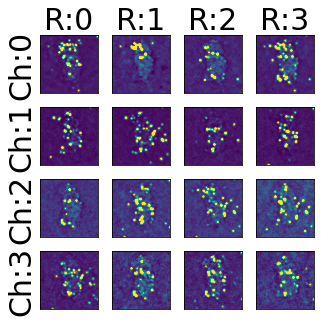

In [5]:
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,:],vmax=10)
bardensr.plotting.plot_rbc(4,4,go,sz=1,sideways=True,notick=True)
plt.savefig("image_based.svg", format='svg', dpi=200, bbox_inches="tight")

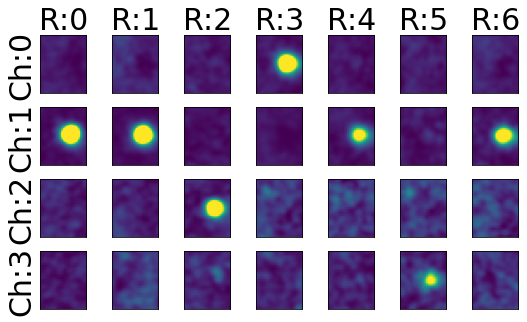

In [6]:
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,25:50,35:55],vmax=10)
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

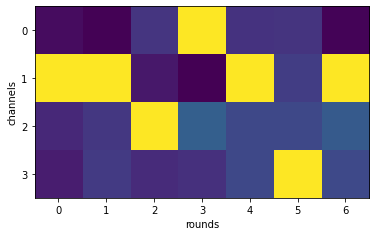

In [7]:
plt.imshow(bench.X[:,:,0,37,47].T,vmax=10)  # look at voxel at (0,37.45)
plt.xlabel("rounds")
plt.ylabel("channels"); plt.yticks(range(4));
plt.savefig("image_heatmap.svg", format='svg', dpi=200, bbox_inches="tight")

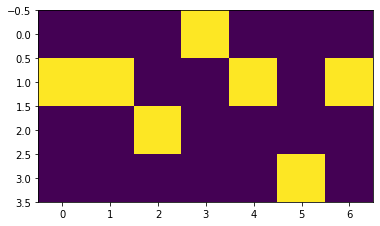

In [8]:
plt.imshow(bench.codebook[:,:,20].T)

In [9]:
# we can identify barcodes quickly using this convenience function:
print("rolonies which show up in channels 1120131 correspond to the following barcodes:",
      bardensr.benchmarks.query_onehot_codebook(bench.codebook,'1120131'))

rolonies which show up in channels 1120131 correspond to the following barcodes: [20]


In [10]:
Xflat = bench.X.reshape((28,)+bench.X.shape[-3:])
codeflat = bench.codebook.reshape((28,-1))
print(Xflat.shape)
print(codeflat.shape)

(28, 1, 200, 200)
(28, 65)


In [11]:
Xnorm = bardensr.preprocessing.minmax(Xflat)
Xnorm = bardensr.preprocessing.background_subtraction(Xnorm,[0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)

2022-09-20 20:12:39.721914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:
2022-09-20 20:12:39.721939: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-20 20:12:39.722413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appr

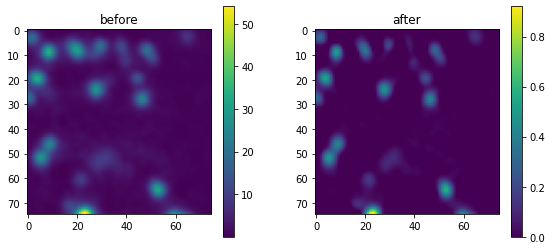

In [12]:
with bardensr.plotting.AnimAcross() as a:
    a('before')
    a.cb(plt.imshow(bench.X[0,0,0][25:100,75:150]))
    
    a('after')
    a.cb(plt.imshow(Xnorm[0,0][25:100,75:150]))
plt.savefig("bgsubtraction.svg", format='svg', dpi=200, bbox_inches="tight")

Text(0, 0.5, 'Frame 1')

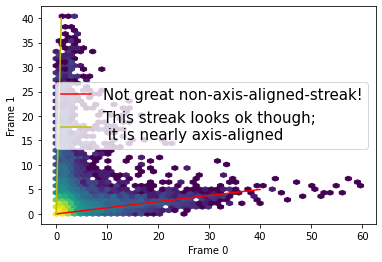

In [13]:
bench_cb=bardensr.load_example('colorbleed_benchmark')
bardensr.preprocessing.colorbleed_plot(bench_cb.X[0,0],bench_cb.X[0,1])
plt.plot([0,40],[0,5],'r-',label='Not great non-axis-aligned-streak!')
plt.plot([0,1],[0,40],'y-',label='This streak looks ok though; \n it is nearly axis-aligned')
plt.legend(fontsize=15)
plt.xlabel("Frame 0")
plt.ylabel('Frame 1')

Text(0, 0.5, 'Frame 1')

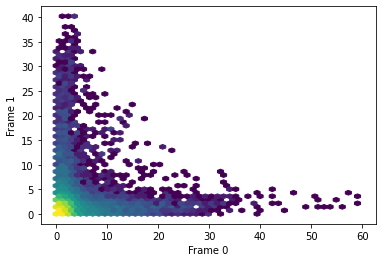

In [14]:
colormixing_matrix=np.array([
    [1,.05,0,0],  # matrix[0,1] is positive because whenever frame 0 is bright, frame 1 is also a bit bright
    [0,1,0,0],
    [0,0,1,0],
    [0,0,0,1],
])
fix=np.linalg.inv(colormixing_matrix)
fixed_imagestack= np.clip(np.einsum('rcxyz,cd->rdxyz',bench_cb.X,fix),0,None)

bardensr.preprocessing.colorbleed_plot(fixed_imagestack[0,0],fixed_imagestack[0,1])
plt.xlabel("Frame 0")
plt.ylabel('Frame 1')

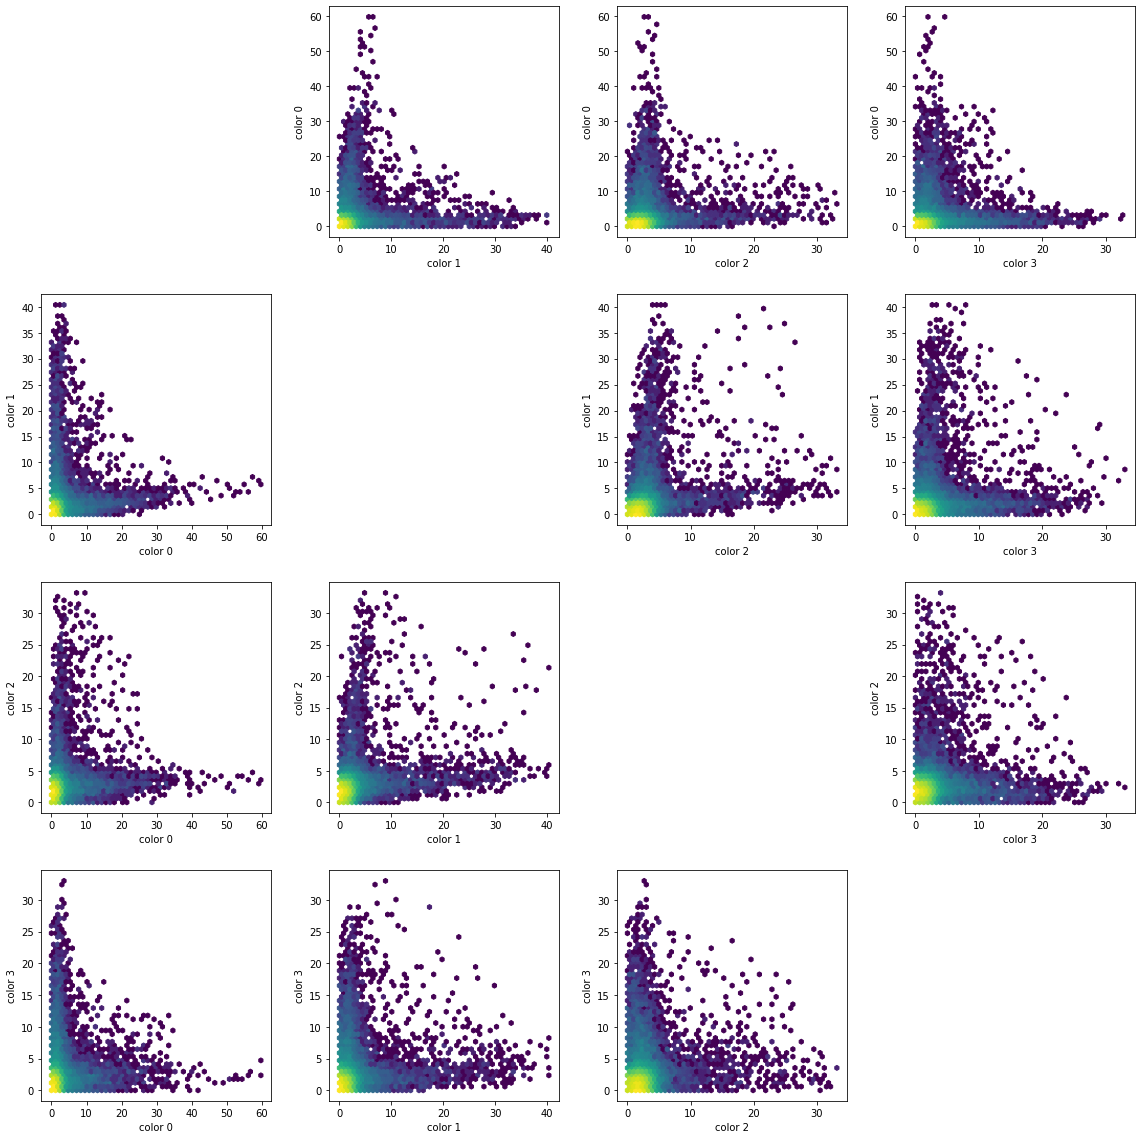

In [15]:
with bardensr.plotting.AnimAcross(columns=4) as a:
    for c in range(4):
        for d in range(4):
            ~a
            if c!=d:
                bardensr.preprocessing.colorbleed_plot(bench_cb.X[0,d],bench_cb.X[0,c])
                plt.xlabel(f'color {d}')
                plt.ylabel(f'color {c}')
            else:
                plt.axis('off')

In [16]:
# we see some action in 1->3, 1->2, 0->1, and just a little in 0->3 so we put the entries in the matrix
colormixing_matrix=np.array([
    [1,.05,0,.025],   # <-- you can usually figuring out reasonable values by trial and error, .05 is a good place to start
    [0,1,.05,.05],
    [0,0,1,0],
    [0,0,0,1],
])
fix=np.linalg.inv(colormixing_matrix)
fixed_imagestack= np.clip(np.einsum('rcxyz,cd->rdxyz',bench_cb.X,fix),0,None)


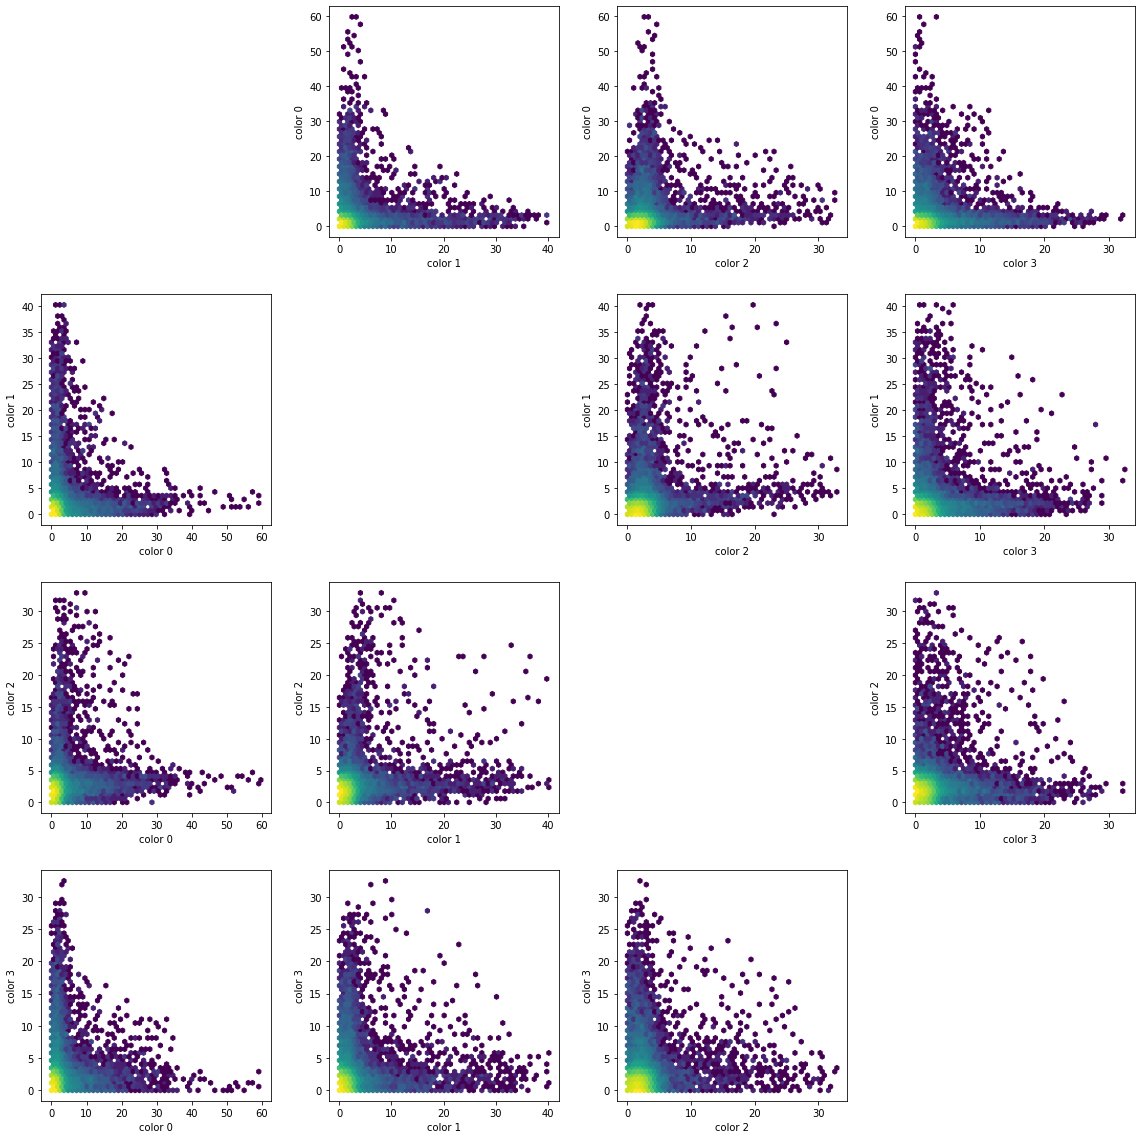

In [17]:
# let's look at the corrected result
with bardensr.plotting.AnimAcross(columns=4) as a:
    for c in range(4):
        for d in range(4):
            ~a
            if c!=d:
                bardensr.preprocessing.colorbleed_plot(fixed_imagestack[0,d],fixed_imagestack[0,c])
                plt.xlabel(f'color {d}')
                plt.ylabel(f'color {c}')
            else:
                plt.axis('off')

In [18]:
# load benchmark
bench=bardensr.load_example('registration_benchmark')

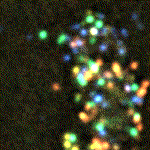

In [19]:
IPython.display.Image(bardensr.plotting.gify(bench.X[:,:,0],normstyle='each'),width=250)

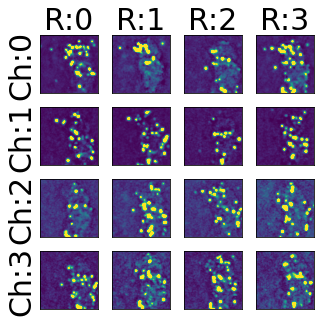

In [20]:
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,:],vmax=10)
bardensr.plotting.plot_rbc(4,4,go,sz=1,sideways=True,notick=True)
plt.savefig("registration.svg", format='svg', dpi=200, bbox_inches="tight")

In [21]:
# preprocess
Xflat = bench.X.reshape((28,)+bench.X.shape[-3:])
codeflat = bench.codebook.reshape((28,-1))
Xnorm = bardensr.preprocessing.minmax(Xflat)
Xnorm = bardensr.preprocessing.background_subtraction(Xnorm,[0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)

In [22]:
# correct registration  (the first time you run this it make take a little while; tensorflow has to compile
# the codes)
corrections=bardensr.registration.find_translations_using_model(Xnorm,codeflat,use_tqdm_notebook=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [23]:
# preprocess
bench=bardensr.load_example('ab701a5a-2dc3-11eb-9890-0242ac110002')
R,C,J=bench.codebook.shape
F=R*C
Xflat = bench.X.reshape((R*C,)+bench.X.shape[-3:])
codeflat = bench.codebook.reshape((28,-1))
Xnorm = bardensr.preprocessing.minmax(Xflat)
Xnorm = bardensr.preprocessing.background_subtraction(Xnorm,[0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)


evidence_tensor=bardensr.spot_calling.estimate_density_singleshot(Xnorm,codeflat,noisefloor=.05)

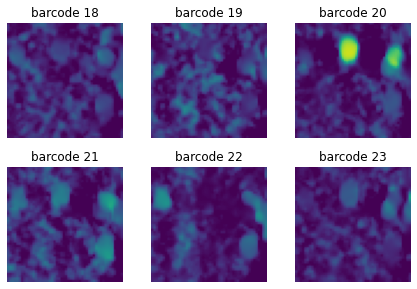

In [24]:
with bardensr.plotting.AnimAcross(sz=2) as a:
    for j in [18,19,20,21,22,23]:
        a(f'barcode {j}')
        plt.imshow(evidence_tensor[0,25:75,25:75,j],vmin=0,vmax=1)
        plt.axis('off')

In [25]:
thresh=.72
result=bardensr.spot_calling.find_peaks(evidence_tensor,thresh)
result

,m0,m1,m2,j
0,0,85,110,1
1,0,87,127,1
2,0,102,142,1
3,0,105,140,1
4,0,114,82,1
...,...,...,...,...
121,0,40,69,50
122,0,45,79,50
123,0,47,71,50
124,0,50,103,50


In [26]:
comparison=bench.rolony_fpfn(result,5)
print("How many false positive?",comparison.fp) # <-- spots that this simple method found that aren't real
print("How many false negatives?",comparison.fn) # <-- spots that this simple method failed to find
print("How many total rolonies detected?",len(result))

How many false positive? 8
How many false negatives? 5
How many total rolonies detected? 126


The simple method thought there was a rolony here with barcode 1


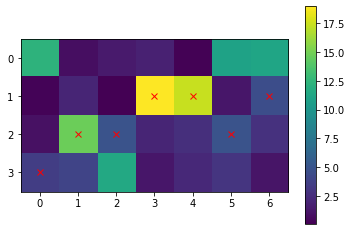

In [27]:
locals().update(dict(comparison.fp_rolonies.iloc[0]))
print("The simple method thought there was a rolony here with barcode",j)
plt.imshow(bench.X[:,:,0,m1,m2].T)
plt.plot(*np.where(bench.codebook[:,:,j]),'rx');
plt.colorbar();

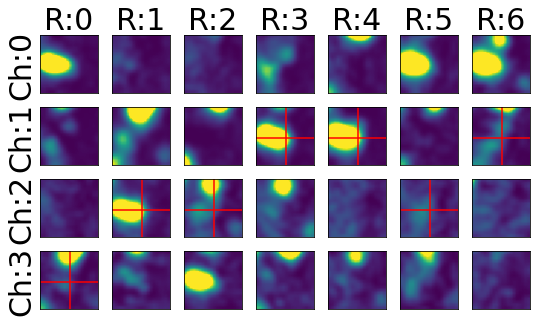

In [28]:
locals().update(dict(comparison.fp_rolonies.iloc[0]))
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,m1-10:m1+10,m2-10:m2+10],vmax=15)
    if bench.codebook[r,c,j]:
        plt.axhline(10,color='red')
        plt.axvline(10,color='red')
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

There's a rolony here with barcode 13 but this simple method failed to find it.


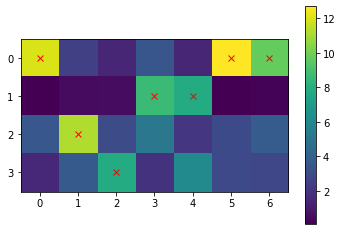

In [29]:
locals().update(dict(comparison.fn_rolonies.iloc[0]))
print("There's a rolony here with barcode",j,"but this simple method failed to find it.")
plt.imshow(bench.X[:,:,0,m1,m2].T)
plt.plot(*np.where(bench.codebook[:,:,j]),'rx');
plt.colorbar()

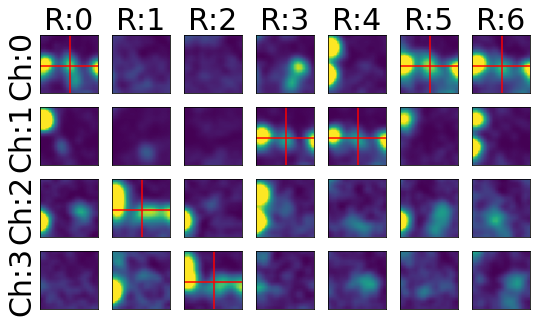

In [30]:

locals().update(dict(comparison.fn_rolonies.iloc[0]))
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,m1-10:m1+10,m2-10:m2+10],vmax=15)
    if bench.codebook[r,c,j]:
        plt.axhline(10,color='red')
        plt.axvline(10,color='red')
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

In [31]:
# preprocess
bench=bardensr.load_example('ab701a5a-2dc3-11eb-9890-0242ac110002')
R,C,J=bench.codebook.shape
F=R*C
Xflat = bench.X.reshape((R*C,)+bench.X.shape[-3:])
codeflat = bench.codebook.reshape((28,-1))
Xnorm = bardensr.preprocessing.minmax(Xflat)
Xnorm = bardensr.preprocessing.background_subtraction(Xnorm,[0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)

In [32]:
evidence_tensor_iterative,extra_learned_params=\
    bardensr.spot_calling.estimate_density_iterative(Xnorm,codeflat,use_tqdm_notebook=True,iterations=100)

  0%|          | 0/100 [00:00<?, ?it/s]

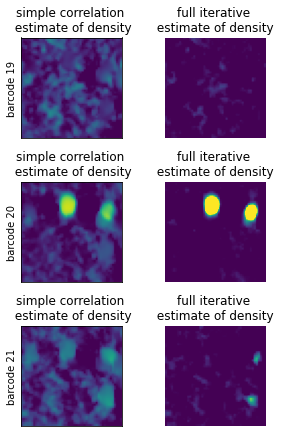

In [33]:
with bardensr.plotting.AnimAcross(sz=2,columns=2,ratio=.7) as a:
    for j in [19,20,21]:
        a(f'simple correlation \n estimate of density')
        plt.imshow(evidence_tensor[0,25:75,25:75,j],vmin=0,vmax=1)
        plt.ylabel(f'barcode {j}')
        plt.xticks([]); plt.yticks([])
        
        a('full iterative \n estimate of density ')
        plt.imshow(evidence_tensor_iterative[0,25:75,25:75,j],vmin=0,vmax=.5)
        plt.axis('off')

Text(0, 0.5, 'channels')

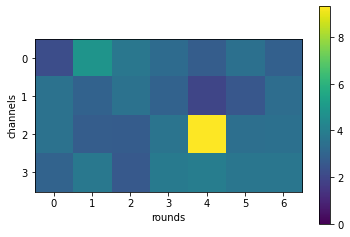

In [34]:
plt.imshow(extra_learned_params['frame_gains'].reshape((7,4)).T,vmin=0)
plt.colorbar()
plt.xlabel("rounds")
plt.ylabel('channels')

In [35]:
thresh_iterative=evidence_tensor_iterative.max()*.1
result_iterative=bardensr.spot_calling.find_peaks(evidence_tensor_iterative,thresh_iterative)
comparison_bardensr=bench.rolony_fpfn(result_iterative,5)
print("How many false positive?",comparison_bardensr.fp) 
print("How many false negatives?",comparison_bardensr.fn)
print("How many total rolonies detected?",len(result_iterative))

How many false positive? 15
How many false negatives? 5
How many total rolonies detected? 131


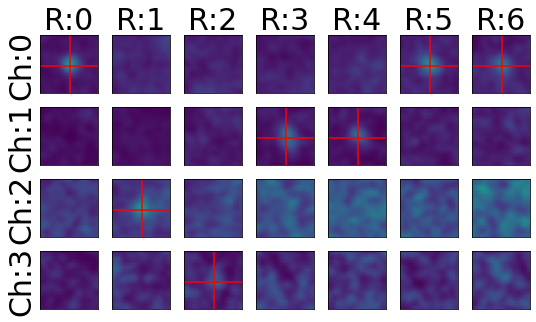

In [36]:
locals().update(dict(comparison_bardensr.fn_rolonies.iloc[1]))
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,m1-10:m1+10,m2-10:m2+10],vmin=0,vmax=10)
    if bench.codebook[r,c,j]:
        plt.axhline(10,color='red')
        plt.axvline(10,color='red')
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

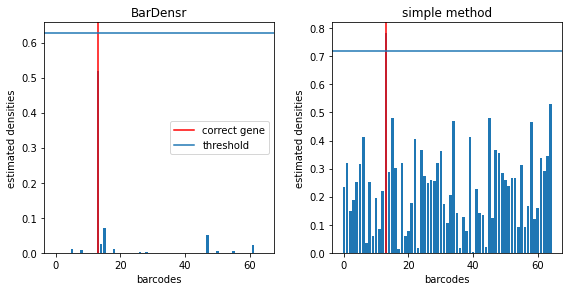

In [37]:
with bardensr.plotting.AnimAcross() as a:
    locals().update(dict(comparison_bardensr.fn_rolonies.iloc[1]))
    
    a('BarDensr')
    plt.bar(range(bench.n_genes),evidence_tensor_iterative[0,m1,m2])
    plt.axvline(j,color='red',label='correct gene')
    plt.axhline(thresh_iterative,color='C0',label='threshold')
    plt.legend()
    plt.ylabel('estimated densities')
    plt.xlabel('barcodes')
    plt.legend()
    
    a('simple method')
    plt.bar(range(bench.n_genes),evidence_tensor[0,m1,m2])
    plt.axvline(j,color='red',label='correct gene')
    plt.axhline(thresh,color='C0')
    plt.ylabel('estimated densities')
    plt.xlabel('barcodes')

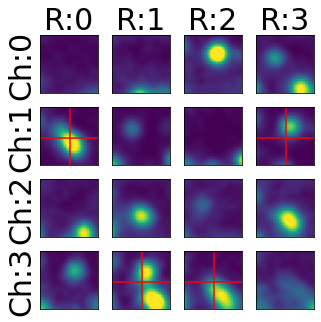

In [38]:
locals().update(dict(comparison_bardensr.fp_rolonies.iloc[1]))
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,m1-10:m1+10,m2-10:m2+10],vmin=0,vmax=30)
    if bench.codebook[r,c,j]:
        plt.axhline(10,color='red')
        plt.axvline(10,color='red')
bardensr.plotting.plot_rbc(4,4,go,sz=1,sideways=True,notick=True)
plt.savefig("spot_calling.svg", format='svg', dpi=200, bbox_inches="tight")